abandonment rate is 20%
so if i asked to authenticate, there is a 20% chance

1 eur everysingle time you want to authenticate, fraud fee

1 euro for true and false postive
10k for each abandoned authenticated over 10% so if 16000 than 160, and ig there should not be more than 160 true positives???


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)
np.random.seed(0)

print("Imports OK ✅")

Imports OK ✅


In [2]:
filename = "/Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/NB6 - Gradient Descent/Fraud_detection.csv"
df = pd.read_csv(filename)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,target
0,-5.387212,4.184541,-1.532484,-1.965818,-2.281421,-0.811241,-1.622605,2.584704,1.691805,2.446557,...,-0.186285,-0.438230,0.446793,-0.057267,0.284110,0.798562,0.871452,0.624266,0.77,0
1,1.191628,-0.241745,1.267706,-0.389685,-1.387590,-1.073890,-0.625846,-0.162185,3.037995,-1.462181,...,-0.118968,0.136868,0.029872,0.886954,0.408935,-0.759999,0.066885,0.036600,11.85,0
2,-0.320070,0.817292,-0.383529,-0.308166,2.602632,3.476013,0.275237,0.873423,-0.674953,0.023649,...,0.072037,0.179752,-0.137884,1.002022,-0.024809,-0.302421,0.410612,0.221219,28.71,0
3,-0.425102,0.986576,1.447792,-0.225688,0.128470,-0.389236,0.580774,0.112083,-0.604489,-0.136107,...,-0.201610,-0.557063,-0.078498,-0.020800,-0.187823,0.074749,0.260763,0.106826,0.89,0
4,1.121653,0.489337,0.511771,2.330934,0.092104,0.165210,-0.001065,0.165187,-0.955771,0.853500,...,0.077408,0.171815,-0.027943,0.002375,0.442279,0.051457,-0.008672,0.003507,0.00,0


In [3]:
# number of target classes
df["target"].value_counts()

target
0    162391
1      2101
Name: count, dtype: int64

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


def evaluate_cost(preds, y_te, transaction_amounts):
    """
    preds: vector of predictions (0 for let go, 1 for authenticate)
    y_te: vector of actual labels (0 for legit, 1 for fraud)
    transaction_amounts: vector containing ONLY the EUR value of each transaction
    """

    # Standard Metrics (Good for monitoring, but not your optimization target)
    precision = precision_score(y_te, preds, zero_division=0)
    recall = recall_score(y_te, preds, zero_division=0)
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f}")

    total_transactions = len(y_te)

    # 1. Count Authentications (Prediction = 1)
    authentication_requested = (preds == 1).sum()

    # 2. Calculate Missed Frauds (False Negatives)
    # We predicted 0 (Let go), but it was 1 (Fraud)
    missed_frauds_indices = np.where((preds == 0) & (y_te == 1))[0]
    missed_frauds_cost = transaction_amounts[missed_frauds_indices].sum()

    # 3. Calculate Abandonment Cost
    # Assumption: 20% of people give up when asked to authenticate
    user_lazy_factor = 0.2
    abandonment_count = authentication_requested * user_lazy_factor
    abandonment_ratio = abandonment_count / total_transactions

    # Logic: 10k for every 1% (0.01) above 10% (0.10)
    # We multiply by 100 to turn 0.01 difference into "1" unit of penalty
    excess_abandonment = max(0, abandonment_ratio - 0.10)
    abandonment_penalty = 10000 * (excess_abandonment * 100)

    # 4. Calculate Auth Fee
    authentication_fee = authentication_requested * 1

    # Total Cost
    total_cost = missed_frauds_cost + authentication_fee + abandonment_penalty

    print(f"--- COST BREAKDOWN ---")
    print(f"Missed Fraud Cost:   €{missed_frauds_cost:,.2f}")
    print(f"Authentication Fees: €{authentication_fee:,.2f}")
    print(
        f"Abandonment Penalty: €{abandonment_penalty:,.2f} (Rate: {abandonment_ratio:.2%})"
    )
    print(f"----------------------")
    print(f"TOTAL COST:          €{total_cost:,.2f}")

    return total_cost

In [5]:
df_clean = df.dropna()
print(f"Number of participants after removing missing values: {len(df_clean)}")

Number of participants after removing missing values: 164492


In [6]:
X = df_clean.drop(columns=["target"]).values
y = df_clean["target"].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (164492, 29)
y shape: (164492,)


In [7]:
# Step 1: Split into train (60%) and temp (40%)
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Step 2: Split temp into val (20% total) and test (20% total)
X_va, X_te, y_va, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=43, stratify=y_tmp
)

In [8]:
print(f"\nTrain set: {X_tr.shape}")
print(f"Val set:   {X_va.shape}")
print(f"Test set:  {X_te.shape}")

# Convert to PyTorch tensors and move to device (MPS/CUDA/CPU)
X_train_t = torch.tensor(X_tr, dtype=torch.float32)
X_val_t = torch.tensor(X_va, dtype=torch.float32)
X_test_t = torch.tensor(X_te, dtype=torch.float32)

y_train_t = torch.tensor(y_tr, dtype=torch.long)
y_val_t = torch.tensor(y_va, dtype=torch.long)
y_test_t = torch.tensor(y_te, dtype=torch.long)

print(f"\nTensors created:")
print(f"X_train_t: {X_train_t.shape}, y_train_t: {y_train_t.shape}")
print(f"X_val_t: {X_val_t.shape}, y_val_t: {y_val_t.shape}")
print(f"X_test_t: {X_test_t.shape}, y_test_t: {y_test_t.shape}")
print(f"Tensors on device: {X_train_t.device}")


Train set: (98695, 29)
Val set:   (32898, 29)
Test set:  (32899, 29)

Tensors created:
X_train_t: torch.Size([98695, 29]), y_train_t: torch.Size([98695])
X_val_t: torch.Size([32898, 29]), y_val_t: torch.Size([32898])
X_test_t: torch.Size([32899, 29]), y_test_t: torch.Size([32899])
Tensors on device: cpu


In [9]:
model = nn.Sequential(
    nn.Linear(29, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)
print(f"Model on device: {next(model.parameters()).device}")

Sequential(
  (0): Linear(in_features=29, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=2, bias=True)
)
Model on device: cpu


In [10]:
# Add this function before the training loop
def accuracy(model, X, y):
    """Calculate accuracy on given data."""
    model.eval()
    with torch.no_grad():
        logits = model(X)
        preds = torch.argmax(logits, dim=1)
        return (preds == y).float().mean().item()

In [11]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

1026


In [12]:
best_val_acc = 0.0
best_weights = None

batch_size = 64
epochs = 50

train_loss_history = []
val_acc_history = []

N = X_train_t.shape[0]

for epoch in range(epochs):
    model.train()
    perm = torch.randperm(N)
    total_loss = 0.0

    for start in range(0, N, batch_size):
        idx = perm[start : start + batch_size]
        xb = X_train_t[idx]
        yb = y_train_t[idx]

        # forward
        logits = model(xb)  # [batch,2]
        loss = loss_fn(logits, yb)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / N
    train_loss_history.append(avg_loss)

    # validation accuracy
    model.eval()
    val_acc = accuracy(model, X_val_t, y_val_t)
    val_acc_history.append(val_acc)

    # save best model so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = {k: v.detach().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch+1:02d}/{epochs}  loss={avg_loss:.4f}  val_acc={val_acc:.4f}")

print("Best validation accuracy:", best_val_acc)

# restore best weights
if best_weights is not None:
    model.load_state_dict(best_weights)

Epoch 01/50  loss=0.0816  val_acc=0.9901
Epoch 02/50  loss=0.0476  val_acc=0.9904
Epoch 03/50  loss=0.0440  val_acc=0.9906
Epoch 04/50  loss=0.0427  val_acc=0.9906
Epoch 05/50  loss=0.0401  val_acc=0.9905
Epoch 06/50  loss=0.0401  val_acc=0.9906
Epoch 07/50  loss=0.0394  val_acc=0.9909
Epoch 08/50  loss=0.0393  val_acc=0.9907
Epoch 09/50  loss=0.0385  val_acc=0.9907
Epoch 10/50  loss=0.0371  val_acc=0.9908
Epoch 11/50  loss=0.0375  val_acc=0.9903
Epoch 12/50  loss=0.0362  val_acc=0.9907
Epoch 13/50  loss=0.0357  val_acc=0.9909
Epoch 14/50  loss=0.0353  val_acc=0.9910
Epoch 15/50  loss=0.0356  val_acc=0.9908
Epoch 16/50  loss=0.0343  val_acc=0.9909
Epoch 17/50  loss=0.0340  val_acc=0.9908
Epoch 18/50  loss=0.0344  val_acc=0.9908
Epoch 19/50  loss=0.0337  val_acc=0.9910
Epoch 20/50  loss=0.0335  val_acc=0.9914
Epoch 21/50  loss=0.0333  val_acc=0.9909
Epoch 22/50  loss=0.0330  val_acc=0.9912
Epoch 23/50  loss=0.0327  val_acc=0.9909
Epoch 24/50  loss=0.0327  val_acc=0.9908
Epoch 25/50  los

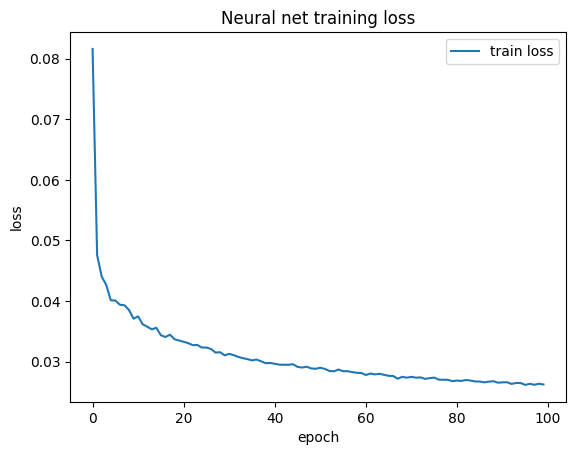

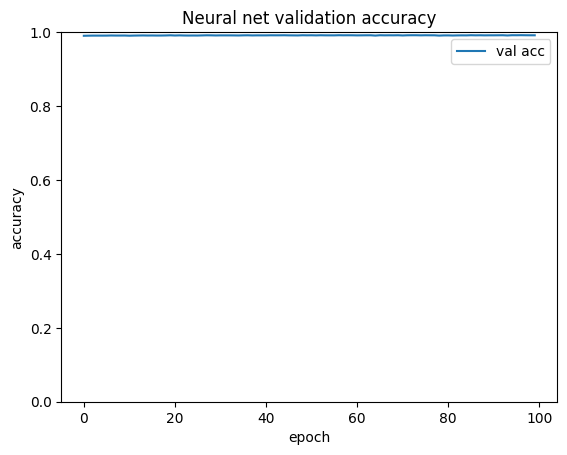

In [93]:
plt.figure()
plt.plot(train_loss_history, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Neural net training loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_acc_history, label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim(0, 1)
plt.title("Neural net validation accuracy")
plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    preds = torch.argmax(logits, dim=1).numpy()

precision = precision_score(y_te, preds)
recall = recall_score(y_te, preds)
f1 = f1_score(y_te, preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8075
Recall: 0.4095
F1 Score: 0.5434


In [ ]:
evaluate_model(preds, y_te, X_te)

Precision: 0.8075
Recall: 0.4095
F1 Score: 0.5434
Total transactions: 32899
missed frauds cost: 80224.18650549077
authentication_requested: 213
abandonment_ratio: 0.0012948721845648804
authentication_fee: 213
Total cost on test set: €80437.18650549077


In [14]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_tr, y_tr)

# Make predictions on test set
log_reg_preds = log_reg.predict(X_te)

# Evaluate with standard metrics
precision = precision_score(y_te, log_reg_preds)
recall = recall_score(y_te, log_reg_preds)
f1 = f1_score(y_te, log_reg_preds)

print("Logistic Regression Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\n" + "=" * 50 + "\n")

# Evaluate with custom cost function
evaluate_model(log_reg_preds, y_te, X_te)

Logistic Regression Results:
Precision: 0.9381
Recall: 0.2167
F1 Score: 0.3520


Precision: 0.9381
Recall: 0.2167
F1 Score: 0.3520
Total transactions: 32899
missed frauds cost: 79445.3727791963
authentication_requested: 97
abandonment_ratio: 0.0005896835770084198
authentication_fee: 97
Total cost on test set: €79542.3727791963


In [16]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting Decision Tree
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb_model.fit(X_tr, y_tr)

# Make predictions on test set
gb_preds = gb_model.predict(X_te)

# Evaluate with standard metrics
precision = precision_score(y_te, gb_preds)
recall = recall_score(y_te, gb_preds)
f1 = f1_score(y_te, gb_preds)

print("Gradient Boosting Decision Tree Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\n" + "=" * 50 + "\n")

# Evaluate with custom cost function
evaluate_model(gb_preds, y_te, X_te)

Gradient Boosting Decision Tree Results:
Precision: 0.8519
Recall: 0.3286
F1 Score: 0.4742


Precision: 0.8519
Recall: 0.3286
F1 Score: 0.4742
Total transactions: 32899
missed frauds cost: 63705.260023787094
authentication_requested: 162
abandonment_ratio: 0.000984832365725402
authentication_fee: 162
Total cost on test set: €63867.260023787094


OPTIMAL THRESHOLD RESULTS
Best threshold: 0.010

Total cost: €10172.15
Authentication requested: 3657
Abandonment ratio: 0.0222 (2.22%)

Metrics:
Precision: 0.0924
Recall: 0.8048
F1 Score: 0.1658

Cost breakdown:
Missed frauds cost: €6515.15
Authentication fee: €3657.00


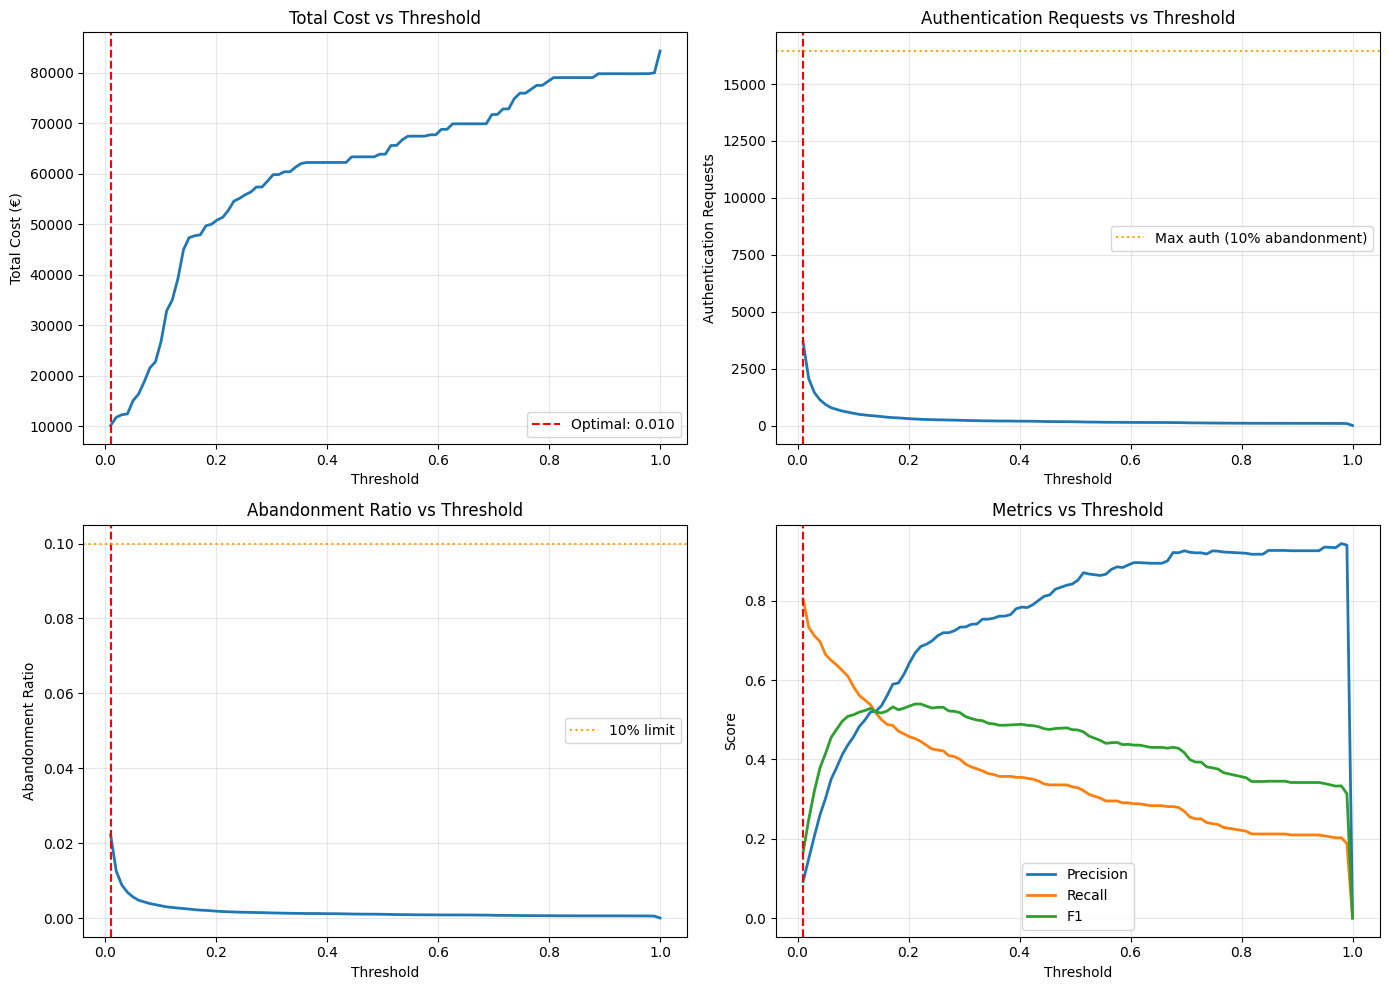


FINAL EVALUATION WITH OPTIMAL THRESHOLD
Precision: 0.0924
Recall: 0.8048
F1 Score: 0.1658
Total transactions: 32899
missed frauds cost: 6515.151474575327
authentication_requested: 3657
abandonment_ratio: 0.022231678774430837
authentication_fee: 3657
Total cost on test set: €10172.151474575327


In [20]:
# Get probability scores instead of hard predictions
gb_proba = gb_model.predict_proba(X_te)[:, 1]

# Test different thresholds
thresholds = np.linspace(0, 1, 100)
results = []

for threshold in thresholds:
    preds = (gb_proba >= threshold).astype(int)

    # Calculate metrics
    total_transactions = len(y_te)
    abandonment_rate = 0.2
    authentication_requested = (preds == 1).sum()

    # Calculate abandonment ratio
    abandonment_count = abandonment_rate * authentication_requested
    abandonment_ratio = abandonment_count / total_transactions

    # Only consider if we don't exceed 10% abandonment
    if abandonment_ratio <= 0.1:
        # Calculate costs
        missed_frauds_indices = np.where((preds == 0) & (y_te == 1))[0]
        missed_frauds_cost = X_te[missed_frauds_indices].sum()
        authentication_fee = authentication_requested * 1
        abandonment_cost = 10000 * max(0, abandonment_ratio - 0.1)
        total_cost = missed_frauds_cost + authentication_fee + abandonment_cost

        # Calculate metrics
        precision = precision_score(y_te, preds, zero_division=0)
        recall = recall_score(y_te, preds, zero_division=0)
        f1 = f1_score(y_te, preds, zero_division=0)

        results.append(
            {
                "threshold": threshold,
                "total_cost": total_cost,
                "auth_requested": authentication_requested,
                "abandonment_ratio": abandonment_ratio,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "missed_frauds_cost": missed_frauds_cost,
                "auth_fee": authentication_fee,
            }
        )

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Find threshold that minimizes cost
best_idx = results_df["total_cost"].idxmin()
best_result = results_df.iloc[best_idx]

print("=" * 60)
print("OPTIMAL THRESHOLD RESULTS")
print("=" * 60)
print(f"Best threshold: {best_result['threshold']:.3f}")
print(f"\nTotal cost: €{best_result['total_cost']:.2f}")
print(f"Authentication requested: {int(best_result['auth_requested'])}")
print(
    f"Abandonment ratio: {best_result['abandonment_ratio']:.4f} ({best_result['abandonment_ratio']*100:.2f}%)"
)
print(f"\nMetrics:")
print(f"Precision: {best_result['precision']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")
print(f"F1 Score: {best_result['f1']:.4f}")
print(f"\nCost breakdown:")
print(f"Missed frauds cost: €{best_result['missed_frauds_cost']:.2f}")
print(f"Authentication fee: €{best_result['auth_fee']:.2f}")

# Plot cost vs threshold
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(results_df["threshold"], results_df["total_cost"], linewidth=2)
plt.axvline(
    best_result["threshold"],
    color="red",
    linestyle="--",
    label=f'Optimal: {best_result["threshold"]:.3f}',
)
plt.xlabel("Threshold")
plt.ylabel("Total Cost (€)")
plt.title("Total Cost vs Threshold")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(results_df["threshold"], results_df["auth_requested"], linewidth=2)
plt.axvline(best_result["threshold"], color="red", linestyle="--")
plt.axhline(
    total_transactions * 0.1 / 0.2,
    color="orange",
    linestyle=":",
    label="Max auth (10% abandonment)",
)
plt.xlabel("Threshold")
plt.ylabel("Authentication Requests")
plt.title("Authentication Requests vs Threshold")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(results_df["threshold"], results_df["abandonment_ratio"], linewidth=2)
plt.axvline(best_result["threshold"], color="red", linestyle="--")
plt.axhline(0.1, color="orange", linestyle=":", label="10% limit")
plt.xlabel("Threshold")
plt.ylabel("Abandonment Ratio")
plt.title("Abandonment Ratio vs Threshold")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(
    results_df["threshold"], results_df["precision"], label="Precision", linewidth=2
)
plt.plot(results_df["threshold"], results_df["recall"], label="Recall", linewidth=2)
plt.plot(results_df["threshold"], results_df["f1"], label="F1", linewidth=2)
plt.axvline(best_result["threshold"], color="red", linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Apply the optimal threshold
optimal_preds = (gb_proba >= best_result["threshold"]).astype(int)
print("\n" + "=" * 60)
print("FINAL EVALUATION WITH OPTIMAL THRESHOLD")
print("=" * 60)
evaluate_model(optimal_preds, y_te, X_te)